# Assignment 6: Tree-Based Methods

## Introduction
In this coursework, you will classify houses into **high price** and **low price** categories based on their characteristics using tree-based methods.

### **Objectives**
- Use the **Ames Housing dataset**, which contains detailed property attributes.
- Train and compare **Decision Tree, Random Forest, and XGBoost** classifiers.
- Evaluate models using **confusion matrices and ROC-AUC**.
- Optimize hyperparameters with **GridSearchCV**.
- Interpret model decisions using **SHAP explainability**.

In [1]:
# Basic packages
import numpy as np
from functools import reduce
from io import BytesIO
import gdown

# Data handling
import pandas as pd
import polars as pl

# Scikit-learn
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# XGBoost
from xgboost import XGBRegressor, XGBClassifier

# Shap
import shap
shap.initjs() # Import Java engine.

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from IPython.display import Image
import pydotplus
from tqdm import tqdm
%matplotlib inline

### **Dataset Description**
The dataset used is the **Ames Housing dataset**, which contains detailed information about residential houses in Ames, Iowa. Each row represents a house, and each column describes a characteristic of that house. Let's understand the **15 most important features** in the dataset:

1. **OverallQual**: The overall material and finish quality of the house.
2. **GrLivArea**: Above ground living area in square feet.
3. **GarageCars**: Number of car spaces in the garage.
4. **TotalBsmtSF**: Total basement area in square feet.
5. **1stFlrSF**: First-floor area in square feet.
6. **FullBath**: Number of full bathrooms.
7. **TotRmsAbvGrd**: Total number of rooms above ground level (excluding bathrooms).
8. **YearBuilt**: Year the house was constructed.
9. **Fireplaces**: Number of fireplaces in the house.
10. **GarageArea**: Size of the garage in square feet.
11. **LotArea**: Total lot size in square feet.
12. **KitchenQual**: Kitchen quality rating.
13. **BsmtFinSF1**: Finished basement square footage.
14. **Neighborhood**: The general location of the property within Ames.
15. **MSSubClass**: Identifies the type of dwelling.


- **Target Variable:** `SalePrice` (converted into a classification task: High vs. Low price).

## **Question 1: Data Preprocessing**
Before training your models, you need to clean and preprocess the dataset.

1. **Load the data `housing.csv` and display the first 5 rows.**

In [2]:
# Load Ames Housing Dataset
data = pl.read_csv("/content/housing.csv")
data.head()

Unnamed: 0,Order,PID,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Exter Qual,Exter Cond,Foundation,Heating,Heating QC,Central Air,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
i64,i64,i64,i64,str,i64,str,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,str,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,str,i64
0,1,526301100,20,"""RL""",31770,"""Pave""","""IR1""","""Lvl""","""AllPub""","""Corner""","""Gtl""","""NAmes""","""Norm""","""Norm""","""1Fam""","""1Story""",6,5,1960,1960,"""Hip""","""CompShg""","""BrkFace""","""Plywood""","""TA""","""TA""","""CBlock""","""GasA""","""Fa""","""Y""",1656,0,0,1656,1,0,3,1,"""TA""",7,"""Typ""",2,"""P""",210,62,0,0,0,0,0,5,2010,"""WD ""","""Normal""",215000
1,2,526350040,20,"""RH""",11622,"""Pave""","""Reg""","""Lvl""","""AllPub""","""Inside""","""Gtl""","""NAmes""","""Feedr""","""Norm""","""1Fam""","""1Story""",5,6,1961,1961,"""Gable""","""CompShg""","""VinylSd""","""VinylSd""","""TA""","""TA""","""CBlock""","""GasA""","""TA""","""Y""",896,0,0,896,1,0,2,1,"""TA""",5,"""Typ""",0,"""Y""",140,0,0,0,120,0,0,6,2010,"""WD ""","""Normal""",105000
2,3,526351010,20,"""RL""",14267,"""Pave""","""IR1""","""Lvl""","""AllPub""","""Corner""","""Gtl""","""NAmes""","""Norm""","""Norm""","""1Fam""","""1Story""",6,6,1958,1958,"""Hip""","""CompShg""","""Wd Sdng""","""Wd Sdng""","""TA""","""TA""","""CBlock""","""GasA""","""TA""","""Y""",1329,0,0,1329,1,1,3,1,"""Gd""",6,"""Typ""",0,"""Y""",393,36,0,0,0,0,12500,6,2010,"""WD ""","""Normal""",172000
3,4,526353030,20,"""RL""",11160,"""Pave""","""Reg""","""Lvl""","""AllPub""","""Corner""","""Gtl""","""NAmes""","""Norm""","""Norm""","""1Fam""","""1Story""",7,5,1968,1968,"""Hip""","""CompShg""","""BrkFace""","""BrkFace""","""Gd""","""TA""","""CBlock""","""GasA""","""Ex""","""Y""",2110,0,0,2110,2,1,3,1,"""Ex""",8,"""Typ""",2,"""Y""",0,0,0,0,0,0,0,4,2010,"""WD ""","""Normal""",244000
4,5,527105010,60,"""RL""",13830,"""Pave""","""IR1""","""Lvl""","""AllPub""","""Inside""","""Gtl""","""Gilbert""","""Norm""","""Norm""","""1Fam""","""2Story""",5,5,1997,1998,"""Gable""","""CompShg""","""VinylSd""","""VinylSd""","""TA""","""TA""","""PConc""","""GasA""","""Gd""","""Y""",928,701,0,1629,2,1,3,1,"""TA""",6,"""Typ""",1,"""Y""",212,34,0,0,0,0,0,3,2010,"""WD ""","""Normal""",189900


In [3]:
# Dropping the ID columns
data = data.drop("Unnamed: 0").drop("Order").drop("PID")
data.head()

MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Exter Qual,Exter Cond,Foundation,Heating,Heating QC,Central Air,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
i64,str,i64,str,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,str,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,str,i64
20,"""RL""",31770,"""Pave""","""IR1""","""Lvl""","""AllPub""","""Corner""","""Gtl""","""NAmes""","""Norm""","""Norm""","""1Fam""","""1Story""",6,5,1960,1960,"""Hip""","""CompShg""","""BrkFace""","""Plywood""","""TA""","""TA""","""CBlock""","""GasA""","""Fa""","""Y""",1656,0,0,1656,1,0,3,1,"""TA""",7,"""Typ""",2,"""P""",210,62,0,0,0,0,0,5,2010,"""WD ""","""Normal""",215000
20,"""RH""",11622,"""Pave""","""Reg""","""Lvl""","""AllPub""","""Inside""","""Gtl""","""NAmes""","""Feedr""","""Norm""","""1Fam""","""1Story""",5,6,1961,1961,"""Gable""","""CompShg""","""VinylSd""","""VinylSd""","""TA""","""TA""","""CBlock""","""GasA""","""TA""","""Y""",896,0,0,896,1,0,2,1,"""TA""",5,"""Typ""",0,"""Y""",140,0,0,0,120,0,0,6,2010,"""WD ""","""Normal""",105000
20,"""RL""",14267,"""Pave""","""IR1""","""Lvl""","""AllPub""","""Corner""","""Gtl""","""NAmes""","""Norm""","""Norm""","""1Fam""","""1Story""",6,6,1958,1958,"""Hip""","""CompShg""","""Wd Sdng""","""Wd Sdng""","""TA""","""TA""","""CBlock""","""GasA""","""TA""","""Y""",1329,0,0,1329,1,1,3,1,"""Gd""",6,"""Typ""",0,"""Y""",393,36,0,0,0,0,12500,6,2010,"""WD ""","""Normal""",172000
20,"""RL""",11160,"""Pave""","""Reg""","""Lvl""","""AllPub""","""Corner""","""Gtl""","""NAmes""","""Norm""","""Norm""","""1Fam""","""1Story""",7,5,1968,1968,"""Hip""","""CompShg""","""BrkFace""","""BrkFace""","""Gd""","""TA""","""CBlock""","""GasA""","""Ex""","""Y""",2110,0,0,2110,2,1,3,1,"""Ex""",8,"""Typ""",2,"""Y""",0,0,0,0,0,0,0,4,2010,"""WD ""","""Normal""",244000
60,"""RL""",13830,"""Pave""","""IR1""","""Lvl""","""AllPub""","""Inside""","""Gtl""","""Gilbert""","""Norm""","""Norm""","""1Fam""","""2Story""",5,5,1997,1998,"""Gable""","""CompShg""","""VinylSd""","""VinylSd""","""TA""","""TA""","""PConc""","""GasA""","""Gd""","""Y""",928,701,0,1629,2,1,3,1,"""TA""",6,"""Typ""",1,"""Y""",212,34,0,0,0,0,0,3,2010,"""WD ""","""Normal""",189900


1. **Convert the `SalePrice` column into a binary classification variable:**
   - If the house price is **above the median**, label it as **1 (High price)**.
   - If the house price is **below the median**, label it as **0 (Low price)**.
   
2. **Drop the original `SalePrice` column** after conversion.

3. **Encode categorical variables**:
   - Some columns contain text (e.g., `Neighborhood`, `House Style`).
   - Convert them into numerical values using **Label Encoding**.

4. **Standardize numerical features**:
   - Scale numerical values to improve model performance.
   - Use `StandardScaler()` from `sklearn.preprocessing`.

5. **Split the dataset into training and testing sets**:
   - Use an **80-20 split** (`train_test_split`).
   - Set `random_state=42` for reproducibility.
   - Use `stratify=y` to maintain class balance.

In [4]:
# 1. Convert SalePrice into a binary target variable (1 for high price, 0 for low price)
saleprice_median = data.select(pl.col("SalePrice").median()).item()
data = data.with_columns((pl.col("SalePrice") > saleprice_median).cast(pl.Int64).alias("SalePrice_binary"))

# 2. Drop original SalePrice column
data = data.drop("SalePrice")
data.head()

MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Exter Qual,Exter Cond,Foundation,Heating,Heating QC,Central Air,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice_binary
i64,str,i64,str,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,str,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,str,i64
20,"""RL""",31770,"""Pave""","""IR1""","""Lvl""","""AllPub""","""Corner""","""Gtl""","""NAmes""","""Norm""","""Norm""","""1Fam""","""1Story""",6,5,1960,1960,"""Hip""","""CompShg""","""BrkFace""","""Plywood""","""TA""","""TA""","""CBlock""","""GasA""","""Fa""","""Y""",1656,0,0,1656,1,0,3,1,"""TA""",7,"""Typ""",2,"""P""",210,62,0,0,0,0,0,5,2010,"""WD ""","""Normal""",1
20,"""RH""",11622,"""Pave""","""Reg""","""Lvl""","""AllPub""","""Inside""","""Gtl""","""NAmes""","""Feedr""","""Norm""","""1Fam""","""1Story""",5,6,1961,1961,"""Gable""","""CompShg""","""VinylSd""","""VinylSd""","""TA""","""TA""","""CBlock""","""GasA""","""TA""","""Y""",896,0,0,896,1,0,2,1,"""TA""",5,"""Typ""",0,"""Y""",140,0,0,0,120,0,0,6,2010,"""WD ""","""Normal""",0
20,"""RL""",14267,"""Pave""","""IR1""","""Lvl""","""AllPub""","""Corner""","""Gtl""","""NAmes""","""Norm""","""Norm""","""1Fam""","""1Story""",6,6,1958,1958,"""Hip""","""CompShg""","""Wd Sdng""","""Wd Sdng""","""TA""","""TA""","""CBlock""","""GasA""","""TA""","""Y""",1329,0,0,1329,1,1,3,1,"""Gd""",6,"""Typ""",0,"""Y""",393,36,0,0,0,0,12500,6,2010,"""WD ""","""Normal""",1
20,"""RL""",11160,"""Pave""","""Reg""","""Lvl""","""AllPub""","""Corner""","""Gtl""","""NAmes""","""Norm""","""Norm""","""1Fam""","""1Story""",7,5,1968,1968,"""Hip""","""CompShg""","""BrkFace""","""BrkFace""","""Gd""","""TA""","""CBlock""","""GasA""","""Ex""","""Y""",2110,0,0,2110,2,1,3,1,"""Ex""",8,"""Typ""",2,"""Y""",0,0,0,0,0,0,0,4,2010,"""WD ""","""Normal""",1
60,"""RL""",13830,"""Pave""","""IR1""","""Lvl""","""AllPub""","""Inside""","""Gtl""","""Gilbert""","""Norm""","""Norm""","""1Fam""","""2Story""",5,5,1997,1998,"""Gable""","""CompShg""","""VinylSd""","""VinylSd""","""TA""","""TA""","""PConc""","""GasA""","""Gd""","""Y""",928,701,0,1629,2,1,3,1,"""TA""",6,"""Typ""",1,"""Y""",212,34,0,0,0,0,0,3,2010,"""WD ""","""Normal""",1


In [5]:
# 3. Encode categorical variables
categorical_features = ['MS Zoning', 'Street', 'Lot Shape', 'Land Contour', 'Utilities',
            'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2',
            'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st',
            'Exterior 2nd', 'Exter Qual', 'Exter Cond', 'Foundation', 'Heating',
            'Heating QC', 'Central Air', 'Kitchen Qual', 'Functional', 'Paved Drive',
            'Sale Type', 'Sale Condition']
categorical_transformer = OneHotEncoder(handle_unknown="ignore", drop="first")
preprocessor = ColumnTransformer(transformers=[("cat", categorical_transformer, categorical_features)],remainder='passthrough')
label_encoder = LabelEncoder()
encode_exprs = [pl.col(feature).cast(pl.Utf8).map_batches(label_encoder.fit_transform).alias(feature) for feature in categorical_features]
data = data.with_columns(encode_exprs)
data.describe()

statistic,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Exter Qual,Exter Cond,Foundation,Heating,Heating QC,Central Air,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice_binary
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",57.387372,4.967235,10147.921843,0.995904,1.940273,2.777816,0.001706,3.05529,0.053584,14.411263,2.040273,2.002048,0.517065,3.023891,6.094881,5.56314,1971.356314,1984.266553,1.394881,1.062799,10.16041,10.87099,2.52901,3.709898,1.392491,1.025256,1.538908,0.933106,1159.557679,335.455973,4.676792,1499.690444,1.566553,0.379522,2.854266,1.044369,2.856314,6.443003,6.691809,0.599317,1.831399,93.751877,47.533447,23.011604,2.592491,16.002048,2.243345,50.635154,6.216041,2007.790444,8.358703,3.779863,0.499317
"""std""",42.638025,0.865652,7880.017759,0.063876,1.412105,0.703199,0.055406,1.603922,0.248304,7.151137,0.872408,0.209038,1.218897,1.910629,1.411026,1.111537,30.245361,20.860286,0.819722,0.538211,3.650608,3.998089,0.701662,0.772393,0.726195,0.245221,1.743942,0.249881,391.890885,428.395715,46.31051,505.508887,0.552941,0.502629,0.827731,0.214076,1.269237,1.572964,1.175414,0.647921,0.536389,126.361562,67.4834,64.139059,25.141331,56.08737,35.597181,566.344288,2.714492,1.316613,1.877433,1.076299,0.500085
"""min""",20.0,0.0,1300.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1872.0,1950.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,334.0,0.0,0.0,334.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2006.0,0.0,0.0,0.0
"""25%""",20.0,5.0,7440.0,1.0,0.0,3.0,0.0,2.0,0.0,7.0,2.0,2.0,0.0,2.0,5.0,5.0,1954.0,1965.0,1.0,1.0,8.0,8.0,2.0,4.0,1.0,1.0,0.0,1.0,876.0,0.0,0.0,1126.0,1.0,0.0,2.0,1.0,2.0,5.0,7.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2007.0,9.0,4.0,0.0
"""50%""",50.0,5.0,9439.0,1.0,3.0,3.0,0.0,4.0,0.0,15.0,2.0,2.0,0.0,2.0,6.0,5.0,1973.0,1993.0,1.0,1.0,13.0,14.0,3.0,4.0,1.0,1.0,0.0,1.0,1084.0,0.0,0.0,1442.0,2.0,0.0,3.0,1.0,4.0,6.0,7.0,1.0,2.0,0.0,27.0,0.0,0.0,0.0,0.0,0.0,6.0,2008.0,9.0,4.0,0.0
"""75%""",70.0,5.0,11556.0,1.0,3.0,3.0,0.0,4.0,0.0,20.0,2.0,2.0,0.0,5.0,7.0,6.0,2001.0,2004.0,1.0,1.0,13.0,14.0,3.0,4.0,2.0,1.0,4.0,1.0,1384.0,704.0,0.0,1743.0,2.0,1.0,3.0,1.0,4.0,7.0,7.0,1.0,2.0,168.0,70.0,0.0,0.0,0.0,0.0,0.0,8.0,2009.0,9.0,4.0,1.0
"""max""",190.0,6.0,215245.0,1.0,3.0,3.0,2.0,4.0,2.0,27.0,8.0,7.0,4.0,7.0,10.0,9.0,2010.0,2010.0,5.0,7.0,15.0,16.0,3.0,4.0,5.0,5.0,4.0,1.0,5095.0,2065.0,1064.0,5642.0,4.0,2.0,8.0,3.0,4.0,15.0,7.0,4.0,2.0,1424.0,742.0,1012.0,508.0,576.0,800.0,17000.0,12.0,2010.0,9.0,5.0,1.0


In [6]:
# 4. Standardize numerical features:
numeric_cols = ['MS SubClass', 'Lot Area', 'Overall Qual',
        'Overall Cond', 'Year Built', 'Year Remod/Add', '1st Flr SF', '2nd Flr SF',
        'Low Qual Fin SF', 'Gr Liv Area', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
        'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Wood Deck SF', 'Open Porch SF',
        'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val',
        'Mo Sold', 'Yr Sold']
scaler = StandardScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])
data.describe()

statistic,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Exter Qual,Exter Cond,Foundation,Heating,Heating QC,Central Air,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice_binary
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0,2930.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",7.7602e-17,4.967235,3.3951e-17,0.995904,1.940273,2.777816,0.001706,3.05529,0.053584,14.411263,2.040273,2.002048,0.517065,3.023891,-5.8201e-17,2.0371e-16,-2.0565e-15,-2.3669e-15,1.394881,1.062799,10.16041,10.87099,2.52901,3.709898,1.392491,1.025256,1.538908,0.933106,6.7902e-17,-1.4550e-16,1.0913e-17,1.9400e-17,2.9101e-16,-1.2610e-16,2.7161e-16,-1.6975e-17,2.856314,-5.8201e-17,6.691809,-4.3651e-17,1.831399,-2.4251e-17,-4.3651e-17,3.3951e-17,3.6376e-18,2.6676e-17,1.3944e-17,1.2125e-18,-1.5520e-16,-8.5285e-14,8.358703,3.779863,0.499317
"""std""",1.000171,0.865652,1.000171,0.063876,1.412105,0.703199,0.055406,1.603922,0.248304,7.151137,0.872408,0.209038,1.218897,1.910629,1.000171,1.000171,1.000171,1.000171,0.819722,0.538211,3.650608,3.998089,0.701662,0.772393,0.726195,0.245221,1.743942,0.249881,1.000171,1.000171,1.000171,1.000171,1.000171,1.000171,1.000171,1.000171,1.269237,1.000171,1.175414,1.000171,0.536389,1.000171,1.000171,1.000171,1.000171,1.000171,1.000171,1.000171,1.000171,1.000171,1.877433,1.076299,0.500085
"""min""",-0.877005,0.0,-1.123022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.611379,-4.105955,-3.285571,-1.64295,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.10696,-0.783185,-0.101005,-2.306368,-2.833614,-0.755203,-3.44889,-4.879322,0.0,-2.825087,0.0,-0.925143,0.0,-0.74206,-0.704493,-0.358838,-0.103134,-0.285354,-0.063031,-0.089422,-1.921881,-1.360118,0.0,0.0,0.0
"""25%""",-0.877005,5.0,-0.343703,1.0,0.0,3.0,0.0,2.0,0.0,7.0,2.0,2.0,0.0,2.0,-0.776079,-0.506718,-0.573948,-0.923757,1.0,1.0,8.0,8.0,2.0,4.0,1.0,1.0,0.0,1.0,-0.723686,-0.783185,-0.101005,-0.739362,-1.024793,-0.755203,-1.032234,-0.207291,2.0,-0.917535,7.0,-0.925143,2.0,-0.74206,-0.704493,-0.358838,-0.103134,-0.285354,-0.063031,-0.089422,-0.816513,-0.600464,9.0,4.0,0.0
"""50%""",-0.173287,5.0,-0.08998,1.0,3.0,3.0,0.0,4.0,0.0,15.0,2.0,2.0,0.0,2.0,-0.067254,-0.506718,0.054354,0.418735,1.0,1.0,13.0,14.0,3.0,4.0,1.0,1.0,0.0,1.0,-0.192836,-0.783185,-0.101005,-0.114143,0.784028,-0.755203,0.176094,-0.207291,4.0,-0.281684,7.0,0.618518,2.0,-0.74206,-0.304326,-0.358838,-0.103134,-0.285354,-0.063031,-0.089422,-0.079602,0.15919,9.0,4.0,0.0
"""75%""",0.295858,5.0,0.17872,1.0,3.0,3.0,0.0,4.0,0.0,20.0,2.0,2.0,0.0,5.0,0.641571,0.393091,0.980274,0.946143,1.0,1.0,13.0,14.0,3.0,4.0,2.0,1.0,4.0,1.0,0.572814,0.860436,-0.101005,0.481398,0.784028,1.234675,0.176094,-0.207291,4.0,0.354167,7.0,0.618518,2.0,0.587685,0.332977,-0.358838,-0.103134,-0.285354,-0.063031,-0.089422,0.65731,0.918845,9.0,4.0,1.0
"""max""",3.110727,6.0,26.031932,1.0,3.0,3.0,2.0,

In [7]:
# 5. Split the dataset into training and testing sets:
# Use an 80-20 split (train_test_split).
# Set random_state=42 for reproducibility.
# Use stratify=y to maintain class balance.

# Define Features (X) and Target (y)
X = data.drop("SalePrice_binary")
y = data["SalePrice_binary"]

# Convert X to NumPy before train-test split
X = X.to_numpy()

# Perform Train-Test Split (with stratification)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## **Question 2: Model Training and Evaluation**
You will train two classification models:
- **Decision Tree** (`random_state = 42`)
- **Random Forest** (`random_state = 42`)

1. **Train the models on the training set. Make sure you use the optimal number of trees for the Random Forest.**.
2. **Evaluate models using the following metrics**:
   - **Confusion Matrix**: Displays True Positives, True Negatives, False Positives, and False Negatives.
   - **ROC-AUC Score**: Measures the model’s ability to distinguish between classes.
   - **ROC Curve**: Plots True Positive Rate (TPR) vs. False Positive Rate (FPR).

3. **Plot the ROC curves for all models in one figure**.

In [8]:
# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
y_proba_dt = dt_model.predict_proba(X_test)[:,1]

In [9]:
# Confusion Matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
print("Decision Tree - Confusion Matrix:\n", cm_dt)

print()

# ROC-AUC
roc_auc_dt = roc_auc_score(y_test, y_proba_dt)
print("Decision Tree - ROC AUC:", roc_auc_dt)

Decision Tree - Confusion Matrix:
 [[250  43]
 [ 28 265]]

Decision Tree - ROC AUC: 0.878839590443686


In [10]:
# Random Forest
param_grid = {'n_estimators': [50, 100, 200, 300]}
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf,
              param_grid=param_grid,
              cv=5,
              scoring='roc_auc',
              n_jobs=-1)

grid_search.fit(X_train, y_train)
print("Best Random Forest Params (1st Try):", grid_search.best_params_)

Best Random Forest Params (1st Try): {'n_estimators': 300}


In [11]:
# Train final Random Forest using the best number of estimators
best_n_estimators = grid_search.best_params_['n_estimators']
rf_best = RandomForestClassifier(n_estimators=best_n_estimators, random_state=42)
rf_best.fit(X_train, y_train)

y_pred_rf = rf_best.predict(X_test)
y_proba_rf = rf_best.predict_proba(X_test)[:, 1]

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("Random Forest - Confusion Matrix:\n", cm_rf)

print()

# ROC-AUC
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
print("Random Forest - ROC AUC:", roc_auc_rf)

Random Forest - Confusion Matrix:
 [[276  17]
 [ 23 270]]

Random Forest - ROC AUC: 0.9793299863714197


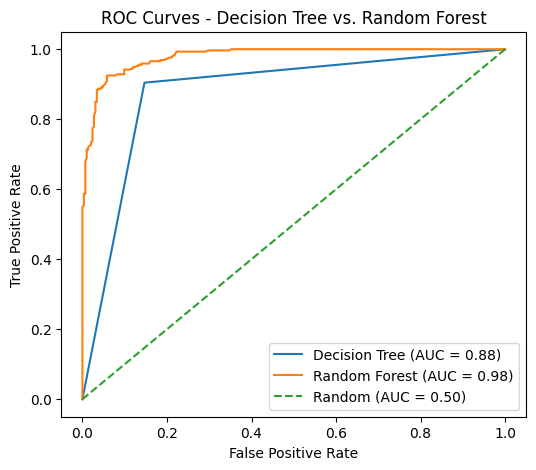

In [12]:
# Plotting 2 Curves
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

plt.figure(figsize=(6, 5))
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {roc_auc_dt:.2f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random (AUC = 0.50)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Decision Tree vs. Random Forest")
plt.legend(loc="lower right")
plt.show()

- The Random Forest has fewer misclassifications in both the false-positive and false-negative categories (17 and 23) compared to the Decision Tree (43 and 28).
- Models have similar performance on true-positive and true-negative.
- The Random Forest achieves a significantly higher ROC-AUC (0.9793 vs. 0.8788).
- Overall, Random Forest is clearly the better performer than a single Decision Tree on this dataset.


## **Question 3: Hyperparameter Tuning**
Hyperparameter tuning helps improve model performance by finding the best parameters.

1. **Tune XGBoost using GridSearchCV with five folds**:
   - Search for the best `n_estimators`, `max_depth`, and `learning_rate`.

2. **Show the best number for each hyperparameter**:

3. **Calculate a ROC curve and its corresponding AUC. Compare these results with the previous models.**

In [13]:
# GridSearch
param_grid_xgb = {"n_estimators": [100, 300, 500],
          "max_depth": [3, 5, 7],
          "learning_rate": [0.1, 0.01, 0.001],}

xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)

grid_search_xgb = GridSearchCV(estimator=xgb_clf,
                param_grid=param_grid_xgb,
                scoring="roc_auc",
                cv=5,
                n_jobs=-1,
                verbose=1)

# Result
grid_search_xgb.fit(X_train, y_train)
print("Best parameters for XGBoost:", grid_search_xgb.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:26:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [14]:
best_params = grid_search_xgb.best_params_
xgb_best = XGBClassifier(
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    learning_rate=best_params["learning_rate"],
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)

xgb_best.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [15]:
y_pred_xgb = xgb_best.predict(X_test)
y_proba_xgb = xgb_best.predict_proba(X_test)[:, 1]

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print("XGBoost - Confusion Matrix:\n", cm_xgb)

print()

# ROC-AUC Score
roc_auc_xgb = roc_auc_score(y_test, y_proba_xgb)
print("XGBoost - ROC AUC:", roc_auc_xgb)

XGBoost - Confusion Matrix:
 [[270  23]
 [ 19 274]]

XGBoost - ROC AUC: 0.9802793276566996


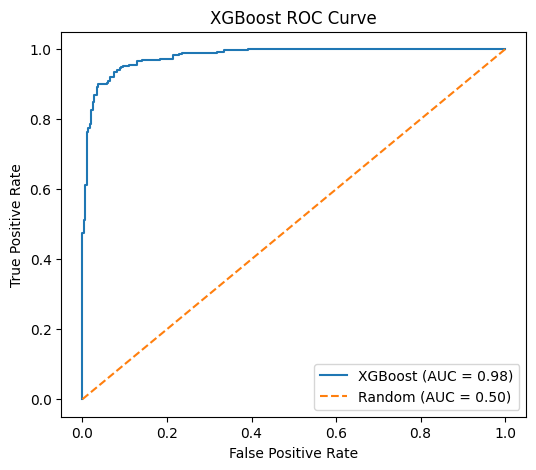

In [16]:
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)

plt.figure(figsize=(6,5))
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {roc_auc_xgb:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random (AUC = 0.50)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost ROC Curve")
plt.legend(loc="lower right")
plt.show()

**Written Answer:**

**XGBoost vs Decision Tree:**
-  XGBoost has a much higher AUC value (0.9803) comparing to the one of Decision Tree (0.8788).
- XGBoost has fewer misclassifications
- XGBoost significantly outperforms the Decision Tree model.

**XGBoost vs Random Forest:**
- They have similar AUC score
- They perform simialr in terms of confusion matrix
- Overall, both are both very strong model and only differ only slightly.

## **Question 4: Model Explainability with SHAP**
Machine learning models can be difficult to interpret. SHAP helps us understand which features are most important in predictions.

1. **Apply SHAP to the best-tuned XGBoost model**.
2. **Generate a SHAP Summary Plot**:
   - Displays the most important features and their impact.
3. **Interpret the results**:
   - Explain the plot for the top three features?
   - Does the result make sense?

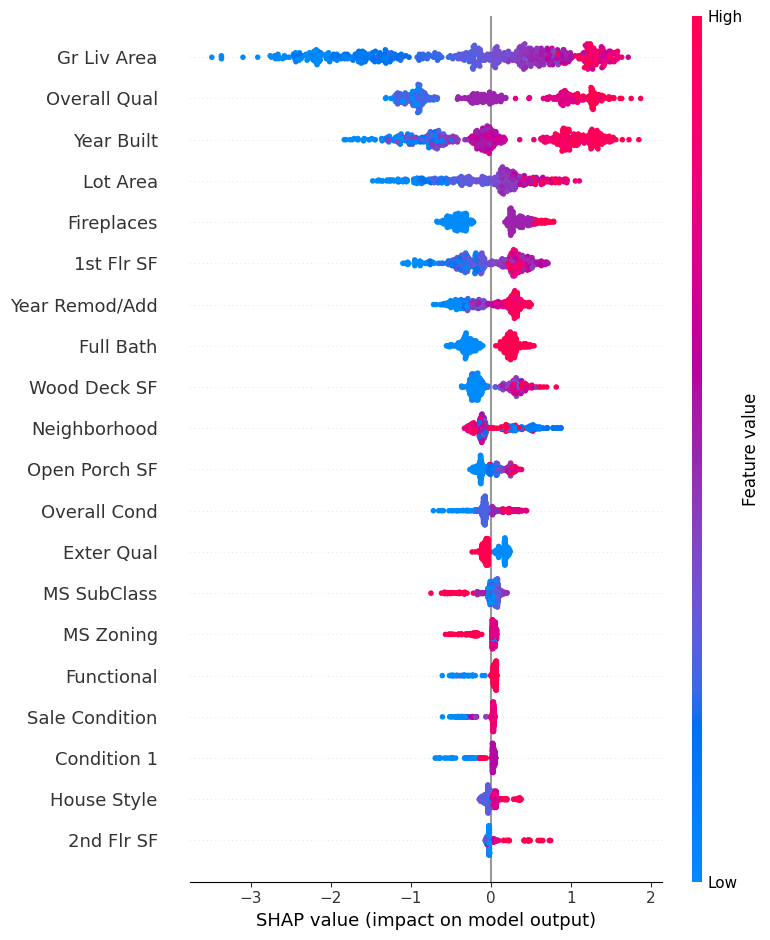

In [17]:
# Use the best-tuned XGBoost model from GridSearch
best_xgb_model = grid_search_xgb.best_estimator_


# Apply SHAP to the best XGBoost model
explainer = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(X_test,check_additivity=False)


# Generate SHAP Summary Plot
shap.summary_plot(
    shap_values,
    features=X_test,
    feature_names=data.columns[:-1],
    plot_type="dot")

**Written Answer:**

**Top three features**
- Gr Liv Area
- Overall Qual
- Year Built

The result makes sense since they are consistent with real-estate intuition:
- Gr Liv Area: Housing with larger living area would be more expensive. Furthermore, if it is much smaller than average, it would have larger negative effect on the housing price.
- Overall Qual: Housing with better overall quality would be more expensive.
- Year Built: Newer houses would be more expensive.